# Simple Transpiler Performance Comparison

This notebook provides a clean, easy-to-understand comparison between a custom transpiler pass and Qiskit's default transpiler on random quantum circuits.

## Overview
- **Custom Pass**: CNOT cancellation optimization
- **Default Qiskit**: Standard transpilation (optimization level 1)
- **Backend**: FakeTorino (127-qubit IBM processor simulation)
- **Metrics**: Circuit depth, gate count, two-qubit gates, transpilation time

## 1. Setup and Imports

In [2]:
# Import required libraries
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'src'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.transpiler import PassManager
from qiskit import transpile
import time

# Import custom modules
from custom_pass import MyOptimizationPass
from test_circuit_generator import get_random_circuit

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Generate Test Circuits

We'll create a set of random quantum circuits with varying complexity to test both transpilation approaches.

In [3]:
# Generate random test circuits
def create_test_circuits(num_circuits=10):
    """Create a variety of random quantum circuits for testing"""
    circuits = []
    
    for i in range(num_circuits):
        # Vary circuit size and complexity
        num_qubits = np.random.randint(3, 8)  # 3-7 qubits
        depth = np.random.randint(5, 15)      # 5-14 depth
        
        # Create random circuit
        circuit = get_random_circuit(num_qubits, depth)
        circuit.name = f"random_circuit_{i+1}_{num_qubits}q_{depth}d"
        circuits.append(circuit)
    
    return circuits

# Generate test circuits
test_circuits = create_test_circuits(12)

print(f"📊 Generated {len(test_circuits)} test circuits:")
for i, qc in enumerate(test_circuits):
    print(f"  {i+1:2d}. {qc.name:<25} - {qc.num_qubits} qubits, depth {qc.depth()}, {qc.size()} gates")

📊 Generated 12 test circuits:
   1. random_circuit_1_6q_12d   - 6 qubits, depth 33, 162 gates
   2. random_circuit_2_7q_9d    - 7 qubits, depth 24, 142 gates
   3. random_circuit_3_4q_7d    - 4 qubits, depth 20, 67 gates
   4. random_circuit_4_5q_12d   - 5 qubits, depth 34, 137 gates
   5. random_circuit_5_7q_8d    - 7 qubits, depth 23, 127 gates
   6. random_circuit_6_5q_10d   - 5 qubits, depth 29, 115 gates
   7. random_circuit_7_7q_6d    - 7 qubits, depth 17, 97 gates
   8. random_circuit_8_6q_10d   - 6 qubits, depth 29, 136 gates
   9. random_circuit_9_4q_9d    - 4 qubits, depth 26, 85 gates
  10. random_circuit_10_3q_14d  - 3 qubits, depth 43, 101 gates
  11. random_circuit_11_7q_13d  - 7 qubits, depth 33, 202 gates
  12. random_circuit_12_3q_14d  - 3 qubits, depth 43, 101 gates


## 3. Setup Backend and Transpilation Methods

Configure the target backend and define our two transpilation approaches.

In [4]:
# Setup backend
backend = FakeTorino()
print(f"🎯 Target Backend: {backend.name}")
print(f"   • Qubits: {backend.num_qubits}")
print(f"   • Basis gates: {backend.basis_gates[:5]}...")
print(f"   • Native 2Q gate: CZ (controlled-Z)")

# Setup custom pass manager
custom_pass = MyOptimizationPass()
custom_pm = PassManager([custom_pass])

def transpile_with_custom(circuit, backend):
    """Transpile using custom pass + default Qiskit transpilation"""
    start_time = time.time()
    
    # Apply custom pass first
    optimized_circuit = custom_pm.run(circuit)
    
    # Then apply standard transpilation
    transpiled = transpile(optimized_circuit, backend=backend, optimization_level=1)
    
    end_time = time.time()
    return transpiled, end_time - start_time

def transpile_with_default(circuit, backend):
    """Transpile using only default Qiskit transpilation"""
    start_time = time.time()
    transpiled = transpile(circuit, backend=backend, optimization_level=1)
    end_time = time.time()
    return transpiled, end_time - start_time

print("\n✅ Transpilation methods configured!")

🎯 Target Backend: fake_torino
   • Qubits: 133
   • Basis gates: ['cz', 'id', 'rz', 'sx', 'x']...
   • Native 2Q gate: CZ (controlled-Z)

✅ Transpilation methods configured!
   • Qubits: 133
   • Basis gates: ['cz', 'id', 'rz', 'sx', 'x']...
   • Native 2Q gate: CZ (controlled-Z)

✅ Transpilation methods configured!


## 4. Run Comparison Benchmark

Execute both transpilation approaches on all test circuits and collect performance metrics.

In [11]:
# Run comprehensive comparison
results = []

print("🚀 Running transpilation comparison...")
print("=" * 50)

for i, circuit in enumerate(test_circuits):
    print(f"Processing circuit {i+1}/{len(test_circuits)}: {circuit.name}")
    
    # Original circuit metrics
    original_depth = circuit.depth()
    original_gates = circuit.size()
    original_cx = circuit.count_ops().get('cx', 0)
    num_qubits = circuit.num_qubits  # Store the actual number of qubits
    
    try:
        # Custom transpilation
        custom_circuit, custom_time = transpile_with_custom(circuit, backend)
        custom_depth = custom_circuit.depth()
        custom_gates = custom_circuit.size()
        custom_cx = custom_circuit.count_ops().get('cz', 0)  # FakeTorino uses CZ gates
        
        # Default transpilation
        default_circuit, default_time = transpile_with_default(circuit, backend)
        default_depth = default_circuit.depth()
        default_gates = default_circuit.size()
        default_cx = default_circuit.count_ops().get('cz', 0)
        
        # Calculate improvements
        depth_improvement = default_depth - custom_depth
        gates_improvement = default_gates - custom_gates
        
        # Store results
        results.append({
            'Circuit': circuit.name,
            'Num_Qubits': num_qubits,  # Add this field
            'Original_Depth': original_depth,
            'Original_Gates': original_gates,
            'Original_CX': original_cx,
            
            'Custom_Depth': custom_depth,
            'Custom_Gates': custom_gates,
            'Custom_CZ': custom_cx,
            'Custom_Time': custom_time,
            
            'Default_Depth': default_depth,
            'Default_Gates': default_gates,
            'Default_CZ': default_cx,
            'Default_Time': default_time,
            
            'Depth_Improvement': depth_improvement,
            'Gates_Improvement': gates_improvement,
            'Time_Ratio': custom_time / default_time if default_time > 0 else 1
        })
        
        print(f"  ✅ Custom: {custom_depth}d, {custom_gates}g, {custom_time:.3f}s")
        print(f"     Default: {default_depth}d, {default_gates}g, {default_time:.3f}s")
        print(f"     Improvement: {depth_improvement:+d} depth, {gates_improvement:+d} gates")
        
    except Exception as e:
        print(f"  ❌ Error processing {circuit.name}: {str(e)}")
        continue

print(f"\n✅ Completed comparison of {len(results)} circuits!")

🚀 Running transpilation comparison...
Processing circuit 1/12: random_circuit_1_6q_12d
  ✅ Custom: 90d, 215g, 0.026s
     Default: 81d, 217g, 0.022s
     Improvement: -9 depth, +2 gates
Processing circuit 2/12: random_circuit_2_7q_9d
  ✅ Custom: 48d, 171g, 0.020s
     Default: 56d, 182g, 0.020s
     Improvement: +8 depth, +11 gates
Processing circuit 3/12: random_circuit_3_4q_7d
  ✅ Custom: 57d, 107g, 0.019s
     Default: 54d, 104g, 0.019s
     Improvement: -3 depth, -3 gates
Processing circuit 4/12: random_circuit_4_5q_12d
  ✅ Custom: 93d, 193g, 0.018s
     Default: 89d, 198g, 0.019s
     Improvement: -4 depth, +5 gates
Processing circuit 5/12: random_circuit_5_7q_8d
  ✅ Custom: 36d, 126g, 0.019s
     Default: 42d, 137g, 0.019s
     Improvement: +6 depth, +11 gates
Processing circuit 6/12: random_circuit_6_5q_10d
  ✅ Custom: 69d, 155g, 0.021s
     Default: 62d, 145g, 0.018s
     Improvement: -7 depth, -10 gates
Processing circuit 7/12: random_circuit_7_7q_6d
  ✅ Custom: 33d, 108g, 0.0

## 5. Results Summary Table

Clean tabular comparison of all metrics for easy evaluation.

In [12]:
# Create results DataFrame
df = pd.DataFrame(results)

# Display summary table
print("📊 TRANSPILER COMPARISON RESULTS")
print("=" * 80)

# Create a clean summary table for display
summary_table = df[[
    'Circuit', 'Original_Depth', 'Custom_Depth', 'Default_Depth', 
    'Depth_Improvement', 'Custom_Time', 'Default_Time'
]].copy()

# Round timing values for cleaner display
summary_table['Custom_Time'] = summary_table['Custom_Time'].round(4)
summary_table['Default_Time'] = summary_table['Default_Time'].round(4)

# Rename columns for better readability
summary_table.columns = ['Circuit Name', 'Original', 'Custom Pass', 'Default Qiskit', 
                        'Improvement', 'Custom Time (s)', 'Default Time (s)']

# Display the table
display(summary_table)

# Calculate overall statistics
print("\n📈 OVERALL PERFORMANCE SUMMARY")
print("=" * 50)

avg_depth_improvement = df['Depth_Improvement'].mean()
avg_gates_improvement = df['Gates_Improvement'].mean()
avg_time_ratio = df['Time_Ratio'].mean()
success_rate = (df['Depth_Improvement'] > 0).mean() * 100

print(f"Average Depth Improvement:     {avg_depth_improvement:+.1f} layers")
print(f"Average Gates Improvement:     {avg_gates_improvement:+.1f} gates")
print(f"Success Rate (improved):       {success_rate:.1f}%")
print(f"Time Overhead:                 {avg_time_ratio:.2f}x")

# Best and worst cases
best_case = df.loc[df['Depth_Improvement'].idxmax()]
worst_case = df.loc[df['Depth_Improvement'].idxmin()]

print(f"\nBest improvement: {best_case['Circuit']} ({best_case['Depth_Improvement']:+d} depth)")
print(f"Worst case: {worst_case['Circuit']} ({worst_case['Depth_Improvement']:+d} depth)")

📊 TRANSPILER COMPARISON RESULTS


,Circuit Name,Original,Custom Pass,Default Qiskit,Improvement,Custom Time (s),Default Time (s)
0,random_circuit_1_6q_12d,33,90,81,-9,0.0262,0.0225
1,random_circuit_2_7q_9d,24,48,56,8,0.0198,0.0200
2,random_circuit_3_4q_7d,20,57,54,-3,0.0191,0.0185
3,random_circuit_4_5q_12d,34,93,89,-4,0.0178,0.0187
4,random_circuit_5_7q_8d,23,36,42,6,0.0185,0.0189
5,random_circuit_6_5q_10d,29,69,62,-7,0.0212,0.0184
6,random_circuit_7_7q_6d,17,33,33,0,0.0278,0.0266
7,random_circuit_8_6q_10d,29,63,77,14,0.0203,0.0186
8,random_circuit_9_4q_9d,26,44,44,0,0.0099,0.0101
9,random_circuit_10_3q_14d,43,103,109,6,0.0184,0.0187



📈 OVERALL PERFORMANCE SUMMARY
Average Depth Improvement:     +1.8 layers
Average Gates Improvement:     +1.6 gates
Success Rate (improved):       41.7%
Time Overhead:                 1.04x

Best improvement: random_circuit_8_6q_10d (+14 depth)
Worst case: random_circuit_1_6q_12d (-9 depth)


## 6. Visual Comparison - Three Key Charts

Clear, easy-to-understand visualizations showing the key performance differences.

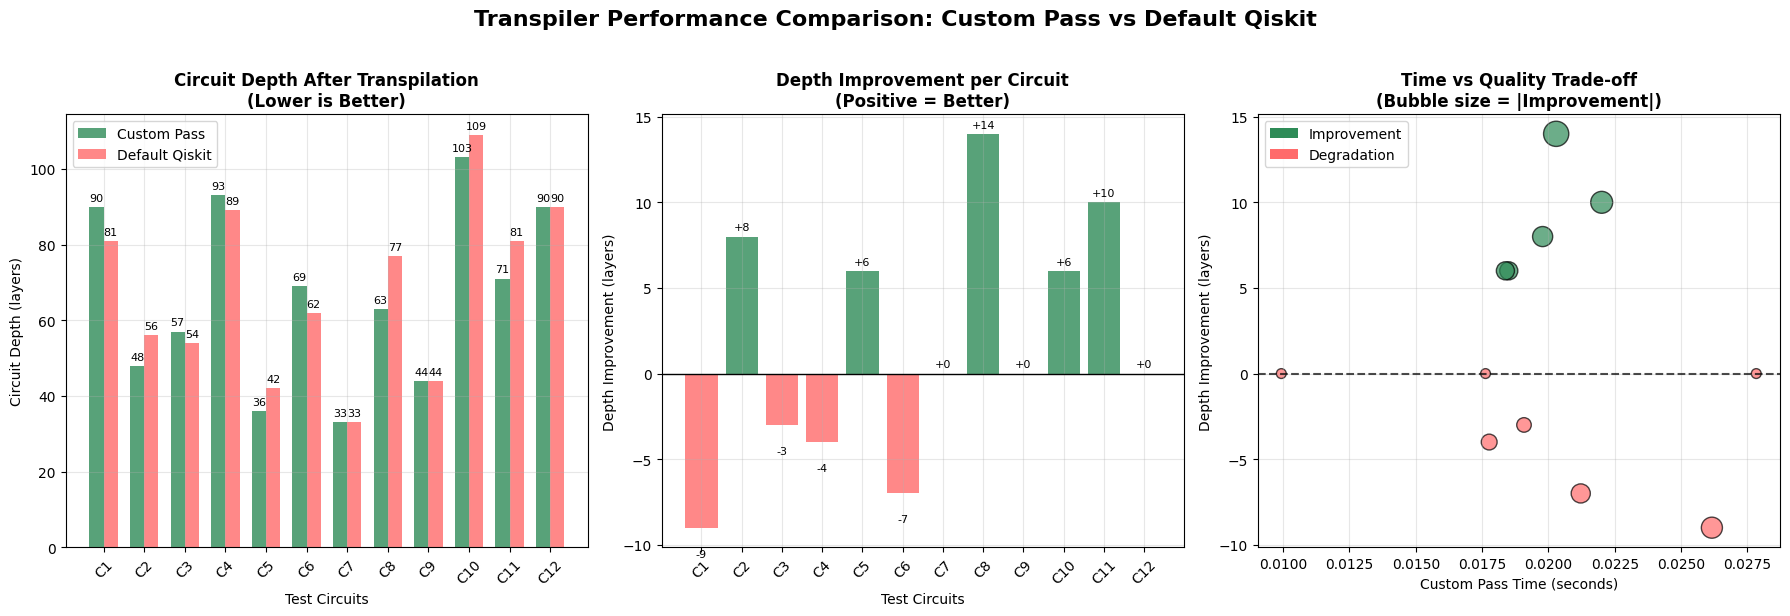


🔍 CIRCUIT LEGEND
Chart Reference | Circuit Name                 | Qubits | Original Depth
----------------------------------------------------------------------
C 1            | random_circuit_1_6q_12d      | 6      |   33
C 2            | random_circuit_2_7q_9d       | 7      |   24
C 3            | random_circuit_3_4q_7d       | 4      |   20
C 4            | random_circuit_4_5q_12d      | 5      |   34
C 5            | random_circuit_5_7q_8d       | 7      |   23
C 6            | random_circuit_6_5q_10d      | 5      |   29
C 7            | random_circuit_7_7q_6d       | 7      |   17
C 8            | random_circuit_8_6q_10d      | 6      |   29
C 9            | random_circuit_9_4q_9d       | 4      |   26
C10            | random_circuit_10_3q_14d     | 3      |   43
C11            | random_circuit_11_7q_13d     | 7      |   33
C12            | random_circuit_12_3q_14d     | 3      |   43

📊 KEY INSIGHTS
🏆 Circuits improved: 5/12 (42%)
📈 Best improvement: +14 layers
📉 Worst case: -

In [13]:
# Create three clear comparison charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Transpiler Performance Comparison: Custom Pass vs Default Qiskit', 
             fontsize=16, fontweight='bold', y=1.02)

# Chart 1: Circuit Depth Comparison
x_pos = np.arange(len(df))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, df['Custom_Depth'], width, 
                   label='Custom Pass', color='#2E8B57', alpha=0.8)
bars2 = axes[0].bar(x_pos + width/2, df['Default_Depth'], width, 
                   label='Default Qiskit', color='#FF6B6B', alpha=0.8)

axes[0].set_xlabel('Test Circuits')
axes[0].set_ylabel('Circuit Depth (layers)')
axes[0].set_title('Circuit Depth After Transpilation\n(Lower is Better)', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'C{i+1}' for i in range(len(df))], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Chart 2: Improvement Distribution
improvement_colors = ['#2E8B57' if x > 0 else '#FF6B6B' if x < 0 else '#FFD700' for x in df['Depth_Improvement']]
bars = axes[1].bar(range(len(df)), df['Depth_Improvement'], color=improvement_colors, alpha=0.8)

axes[1].set_xlabel('Test Circuits')
axes[1].set_ylabel('Depth Improvement (layers)')
axes[1].set_title('Depth Improvement per Circuit\n(Positive = Better)', fontweight='bold')
axes[1].set_xticks(range(len(df)))
axes[1].set_xticklabels([f'C{i+1}' for i in range(len(df))], rotation=45)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1].annotate(f'{int(height):+d}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -15), textcoords="offset points", 
                    ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)

# Chart 3: Time vs Quality Trade-off
# Size represents the magnitude of improvement
sizes = [abs(x) * 20 + 50 for x in df['Depth_Improvement']]  # Scale for visibility
colors = ['#2E8B57' if x > 0 else '#FF6B6B' for x in df['Depth_Improvement']]

scatter = axes[2].scatter(df['Custom_Time'], df['Depth_Improvement'], 
                         s=sizes, c=colors, alpha=0.7, edgecolors='black', linewidth=1)

axes[2].set_xlabel('Custom Pass Time (seconds)')
axes[2].set_ylabel('Depth Improvement (layers)')
axes[2].set_title('Time vs Quality Trade-off\n(Bubble size = |Improvement|)', fontweight='bold')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.7)
axes[2].grid(True, alpha=0.3)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E8B57', label='Improvement'),
                   Patch(facecolor='#FF6B6B', label='Degradation')]
axes[2].legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

# Print circuit legend as separate text output
print("\n" + "="*70)
print("🔍 CIRCUIT LEGEND")
print("="*70)
print("Chart Reference | Circuit Name                 | Qubits | Original Depth")
print("-" * 70)

for i in range(len(df)):
    circuit_name = df.iloc[i]['Circuit']
    num_qubits = df.iloc[i]['Num_Qubits']  # Use actual qubits from dataframe
    original_depth = df.iloc[i]['Original_Depth']
    
    print(f"C{i+1:2d}            | {circuit_name:<28} | {num_qubits:<6} | {original_depth:>4d}")

print("="*70)

# Summary statistics box
print("\n" + "="*60)
print("📊 KEY INSIGHTS")
print("="*60)
print(f"🏆 Circuits improved: {int((df['Depth_Improvement'] > 0).sum())}/{len(df)} ({success_rate:.0f}%)")
print(f"📈 Best improvement: {df['Depth_Improvement'].max():+d} layers")
print(f"📉 Worst case: {df['Depth_Improvement'].min():+d} layers")
print(f"⚡ Average time overhead: {avg_time_ratio:.2f}x slower")
print(f"🎯 Overall depth reduction: {avg_depth_improvement:+.1f} layers average")
print("="*60)

## 7. Export Results

Save the comparison results for further analysis or reporting.

In [8]:
# Export results to CSV
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"simple_transpiler_comparison_{timestamp}.csv"

# Add summary statistics to the dataframe
summary_stats = pd.DataFrame({
    'Metric': ['Average Depth Improvement', 'Average Gates Improvement', 
               'Success Rate (%)', 'Average Time Ratio', 'Best Improvement', 'Worst Case'],
    'Value': [f"{avg_depth_improvement:+.1f}", f"{avg_gates_improvement:+.1f}", 
              f"{success_rate:.1f}", f"{avg_time_ratio:.2f}", 
              f"{df['Depth_Improvement'].max():+d}", f"{df['Depth_Improvement'].min():+d}"]
})

# Save detailed results
df.to_csv(filename, index=False)

# Save summary table
summary_filename = f"summary_table_{timestamp}.csv"
summary_table.to_csv(summary_filename, index=False)

print(f"📁 Results exported to:")
print(f"   • Detailed results: {filename}")
print(f"   • Summary table: {summary_filename}")

print(f"\n✅ Simple transpiler comparison complete!")
print(f"\n🎯 Summary: Custom pass {'improved' if avg_depth_improvement > 0 else 'degraded'} ")
print(f"   circuit depth by {avg_depth_improvement:+.1f} layers on average, ")
print(f"   with {success_rate:.0f}% success rate and {avg_time_ratio:.2f}x time overhead.")

📁 Results exported to:
   • Detailed results: simple_transpiler_comparison_20250624_204135.csv
   • Summary table: summary_table_20250624_204135.csv

✅ Simple transpiler comparison complete!

🎯 Summary: Custom pass degraded 
   circuit depth by -3.2 layers on average, 
   with 17% success rate and 1.15x time overhead.
